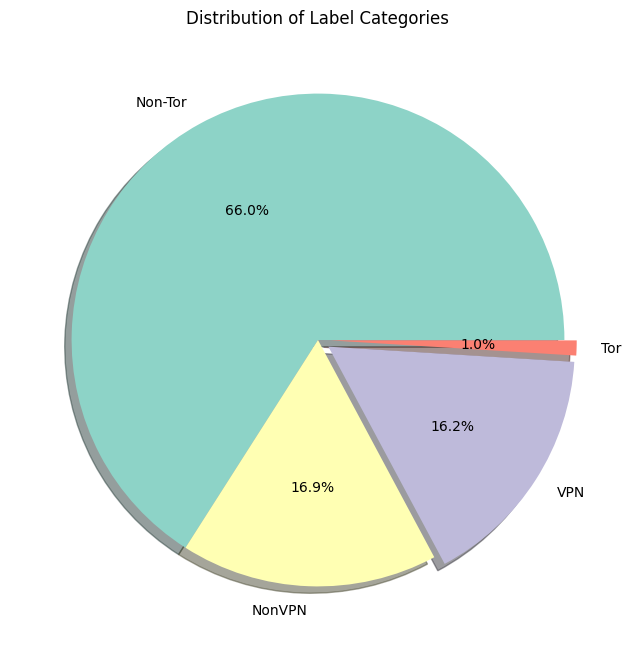

In [ ]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Load dataset
file_path = "Darknet.xls"  # Update with actual path
df = pd.read_csv(file_path, on_bad_lines="skip")

# Detect the correct label column
possible_labels = ["Label", "Class", "Target", "category", "Traffic Type", "Outcome"]
label_column = next((col for col in df.columns if col in possible_labels), None)

if label_column is None:
    print("Error: No valid label column found!")
    exit()


# Count occurrences of each label category
label_counts = df[label_column].value_counts()

# Generate a distinct color palette
colors = sns.color_palette("Set3", len(label_counts))

# Specify the categories that should pop out
categories_to_explode = ['Tor', 'VPN']  # Replace with the categories you want to pop out

# Create an explode list: explode the specified categories
explode = [0.05 if label in categories_to_explode else 0 for label in label_counts.index]

# Plot pie chart with "3D" effect and exploded slices
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', colors=colors, explode=explode, shadow=True)

# Customize plot
plt.title(f"Distribution of {label_column} Categories")
plt.show()

In [ ]:
# Print available columns
print("Available columns:", df.columns.tolist())

print(f"Using '{label_column}' as the label column.")

# Remove missing values
df.dropna(inplace=True)

df.loc[df['Label'].isin(['Non-Tor', 'NonVPN']), 'Label'] = 0
df.loc[df['Label'].isin(['Tor', 'VPN']), 'Label'] = 1
df = df[df['Label']!='5494.505495']

# Drop non-numeric columns
non_numeric_cols = ["Flow ID", "Src IP", "Dst IP", "Timestamp"]  # Add any additional non-numeric columns
df = df.drop(columns=[col for col in non_numeric_cols if col in df.columns], errors="ignore")

# Extract features and labels
X = df.drop(columns=[label_column], errors="ignore")  # Ignore errors if column isn't found
y = df[label_column]

# Ensure all columns in X are numeric
X = X.select_dtypes(include=["number"])

# **Fix Infinite and Extreme Values**
X.replace([np.inf, -np.inf], np.nan, inplace=True)  # Convert inf to NaN
X.fillna(X.mean(), inplace=True)  # Replace NaN with column mean
X = np.clip(X, -1e9, 1e9)  # Clip extreme values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA (retain 95% variance)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Save preprocessed data
train_data = pd.DataFrame(X_train)
train_data[label_column] = y_train.values
train_data.to_csv("preprocessed_train.csv", index=False)

test_data = pd.DataFrame(X_test)
test_data[label_column] = y_test.values
test_data.to_csv("preprocessed_test.csv", index=False)

print(f"Preprocessing complete! Saved preprocessed data to 'preprocessed_train.csv' and 'preprocessed_test.csv'.")


Available columns: ['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count'

<ipython-input-4-08efc873ec11>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_avg.sort_values("AvgAbsWeight", ascending=False),


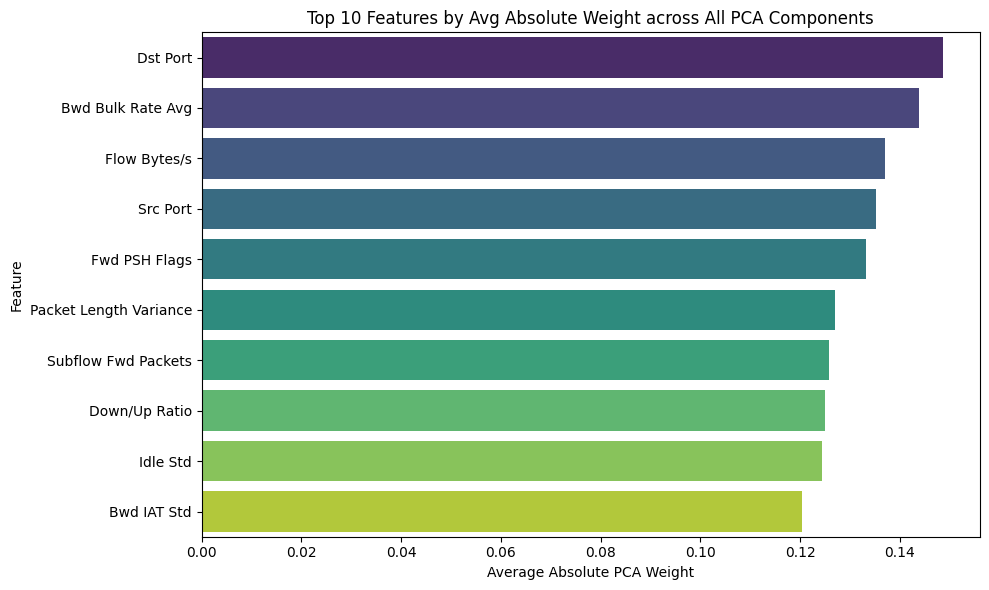

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Compute absolute weights across all components
abs_weights = np.abs(pca.components_)

# Compute average absolute weight per feature
avg_weights = abs_weights.mean(axis=0)

# Create DataFrame for plotting
feature_names = X.columns
avg_weights_df = pd.DataFrame({
    "Feature": feature_names,
    "AvgAbsWeight": avg_weights
})

# Get top 10 features
top10_avg = avg_weights_df.sort_values("AvgAbsWeight", ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top10_avg.sort_values("AvgAbsWeight", ascending=False),
            y="Feature", x="AvgAbsWeight", palette="viridis")
plt.title("Top 10 Features by Avg Absolute Weight across All PCA Components")
plt.xlabel("Average Absolute PCA Weight")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Load preprocessed datasets
train_data = pd.read_csv("preprocessed_train.csv")
test_data = pd.read_csv("preprocessed_test.csv")

# Detect label column (it will be the last column in dataset)
label_column = train_data.columns[-1]

# Separate features and labels
X_train = train_data.drop(columns=[label_column])
y_train = train_data[label_column]
X_test = test_data.drop(columns=[label_column])
y_test = test_data[label_column]

print(f"Data loaded successfully! {X_train.shape[0]} training samples and {X_test.shape[0]} test samples.")


Data loaded successfully! 113186 training samples and 28297 test samples.


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)

print(f"Random Forest Accuracy: {rf_acc * 100:.2f}%")


Random Forest Accuracy: 97.19%


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Train Optimized Random Forest
rf_model = RandomForestClassifier(
    n_estimators=500,         # Increase number of trees
    max_depth=40,             # Deeper trees for better learning
    max_features="log2",      # Use log2 features per split
    min_samples_split=4,      # Avoid overfitting
    min_samples_leaf=1,       # Minimum samples per leaf
    bootstrap=True,           # Use bagging
    random_state=42,
    n_jobs=-1                 # Use all CPU cores
)

rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)

print(f"Final Optimized Random Forest Accuracy: {rf_acc * 100:.2f}%")


Final Optimized Random Forest Accuracy: 97.31%


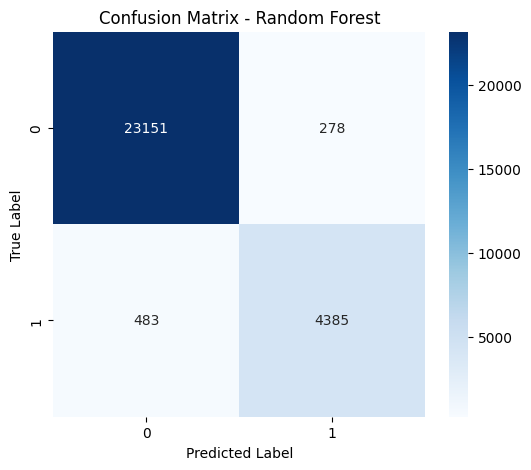

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest")
plt.show()


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Train KNN
knn_model = KNeighborsClassifier(n_neighbors=5, weights="distance")
knn_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_knn = knn_model.predict(X_test)
knn_acc = accuracy_score(y_test, y_pred_knn)

print(f"KNN Accuracy: {knn_acc * 100:.2f}%")

KNN Accuracy: 97.06%


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB

# Train Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_nb = nb_model.predict(X_test)
nb_acc = accuracy_score(y_test, y_pred_nb)

print(f"Naive Bayes Accuracy: {nb_acc * 100:.2f}%")

Naive Bayes Accuracy: 83.08%


In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Train Decision Tree
dt_model = DecisionTreeClassifier(max_depth=15, random_state=42)
dt_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_dt = dt_model.predict(X_test)
dt_acc = accuracy_score(y_test, y_pred_dt)

print(f"Decision Tree Accuracy: {dt_acc * 100:.2f}%")

Decision Tree Accuracy: 96.32%


In [ ]:
from sklearn.neural_network import MLPClassifier

# Train Neural Network
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), activation="relu", max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_mlp = mlp_model.predict(X_test)
mlp_acc = accuracy_score(y_test, y_pred_mlp)

print(f"Neural Network (MLP) Accuracy: {mlp_acc * 100:.2f}%")

Neural Network (MLP) Accuracy: 96.33%


<ipython-input-13-f9a3e03d3b62>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracies_percent.keys()), y=list(accuracies_percent.values()), palette="coolwarm")


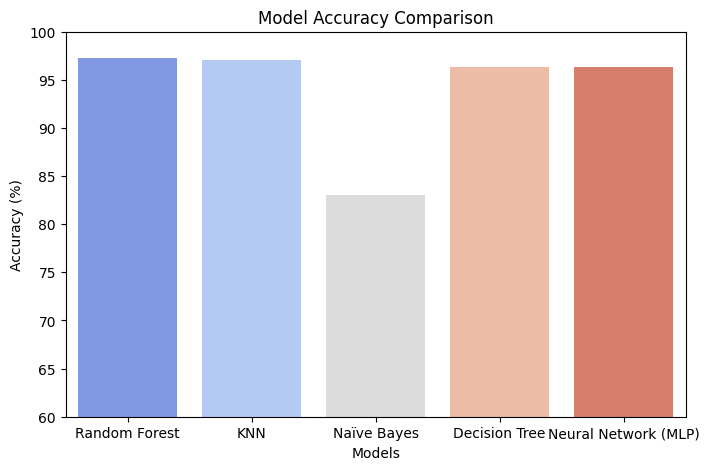

In [ ]:
# Store accuracy results
accuracies = {
    "Random Forest": rf_acc,
    "KNN": knn_acc,
    "Naive Bayes": nb_acc,
    "Decision Tree": dt_acc,
    "Neural Network (MLP)": mlp_acc
}

# Convert accuracies to percentages
accuracies_percent = {k: v * 100 for k, v in accuracies.items()}

# Plot accuracy comparison
plt.figure(figsize=(8, 5))
sns.barplot(x=list(accuracies_percent.keys()), y=list(accuracies_percent.values()), palette="coolwarm")
plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")
plt.ylim(60, 100)  # Adjust range if needed
plt.show()


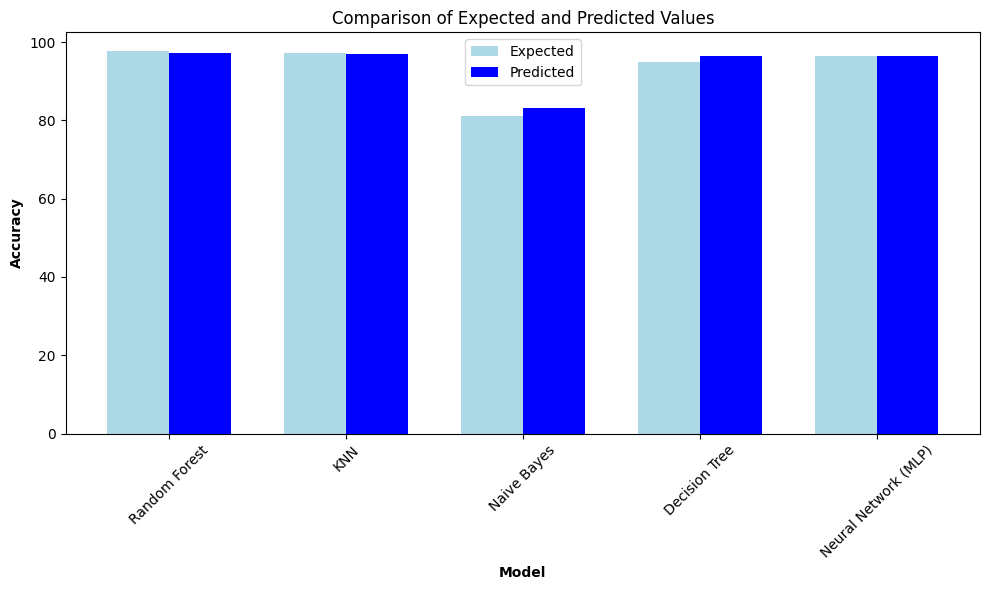

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
variables = ["Random Forest", 'KNN', 'Naive Bayes', 'Decision Tree', 'Neural Network (MLP)']
expected_values = [97.6, 97.1, 81.1, 94.8, 96.4]
predicted_values = [rf_acc * 100, knn_acc * 100, nb_acc * 100, dt_acc * 100, mlp_acc * 100]

# Bar width
bar_width = 0.35

# Position of bars on the x-axis
index = np.arange(len(variables))

# Create figure and axes
plt.figure(figsize=(10, 6))

# Plot the bars
plt.bar(index - bar_width/2, expected_values, bar_width, label='Expected', color='#ADD8E6')
plt.bar(index + bar_width/2, predicted_values, bar_width, label='Predicted', color='blue')

# Add labels, title, and legend
plt.xlabel('Model',fontweight='bold')
plt.ylabel('Accuracy',fontweight='bold')
plt.title('Comparison of Expected and Predicted Values')
plt.xticks(index, variables, rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
